Чтобы понять состояние здоровья растения, надо вычислить отношение между разностью интенсивностей отраженного света в красном (Red) и инфракрасном диапазоне (Nir) и их суммой. Это и есть NDVI.
Все значения индекса лежат в диапазоне от -1 до 1, то есть «нормализовать» для более лёгкого сравнения между собой. Значения NDVI от -1 до 0 это объекты неживой природы и инфраструктуры — снег, вода, песок, камни, дома, дороги и т. п. Значения для растений лежат в диапазоне от 0 до 1.

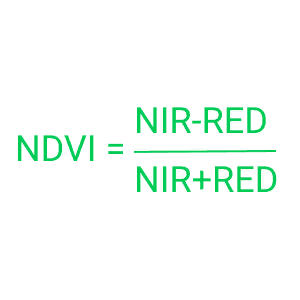

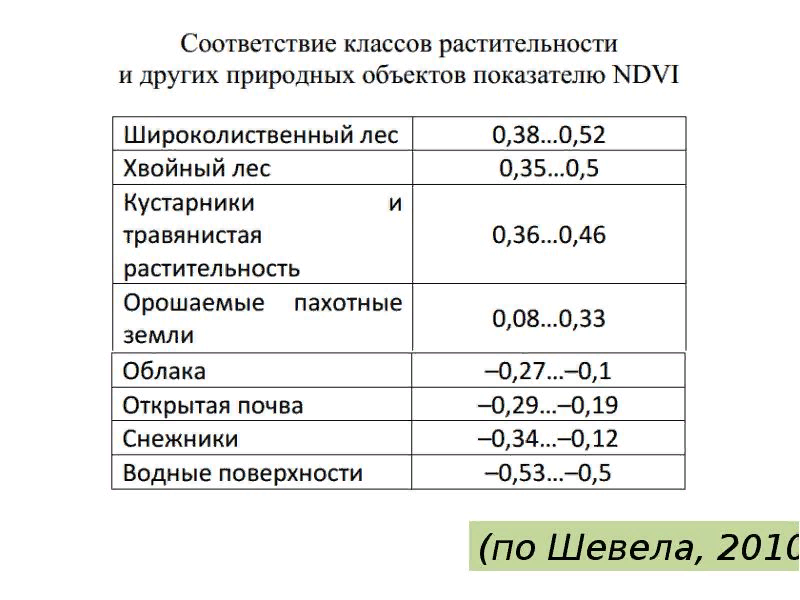

In [1]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

full = train.append(test).reset_index()
full.is_train = 0
full.loc[~full.Culture.isnull(), 'is_train']= 1
full.loc[full.Culture.isnull(), 'is_train'] = 0

print(train.shape, test.shape)

(2838, 370) (939, 369)


In [3]:
train.head(5)

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,...,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
0,2018,517,48.64,0.5369,0.5371,0.5375,0.5379,0.5384,0.5390,0.5397,...,0.4362,0.4322,0.4283,0.4243,0.4203,0.4163,0.4123,0.4084,NaN,4
1,2019,1395,80.41,0.1159,0.1096,0.1034,0.0971,0.0909,0.0846,0.0783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,2017,44,43.64,-0.0204,-0.0207,-0.0210,-0.0212,-0.0215,-0.0218,-0.0220,...,0.0833,0.1149,0.1466,0.1782,0.2099,0.2415,0.2732,0.3048,NaN,2
3,2018,1591,79.34,0.4827,0.4576,0.4324,0.4073,0.3821,0.3570,0.3318,...,0.2657,0.2668,0.2680,0.2692,0.2705,0.2717,0.2730,0.2743,NaN,4
4,2017,681,144.76,-0.0202,-0.0191,-0.0181,-0.0170,-0.0160,-0.0150,-0.0140,...,-0.0354,-0.0358,-0.0361,-0.0365,-0.0369,-0.0372,-0.0376,-0.0379,NaN,4


# EDA

In [4]:
train.describe()

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,...,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,2362.000000,447.000000,2838.000000
mean,2017.259338,845.647639,106.608302,0.207495,0.205959,0.204435,0.202948,0.201810,0.200738,0.199660,...,0.198520,0.196360,0.191499,0.186658,0.181817,0.177668,0.173420,0.168890,0.088671,6.200141
std,1.255671,605.755332,72.944998,0.212510,0.211975,0.211715,0.211787,0.211938,0.212393,0.213124,...,0.195781,0.195195,0.192634,0.190466,0.188438,0.186766,0.185895,0.185588,0.126895,4.159082
min,2015.000000,1.000000,5.990000,-0.141800,-0.133400,-0.126600,-0.124800,-0.122200,-0.121200,-0.125400,...,-0.161000,-0.158000,-0.155000,-0.152000,-0.157700,-0.167000,-0.158600,-0.150200,-0.137000,1.000000
25%,2016.000000,255.250000,63.380000,0.010575,0.008750,0.007000,0.005225,0.003100,0.001000,-0.000275,...,0.004125,0.005000,0.007350,0.003575,0.000750,-0.000400,0.000025,-0.000575,-0.013150,4.000000
50%,2017.000000,743.500000,87.185000,0.154000,0.155200,0.151300,0.154100,0.155650,0.152600,0.154550,...,0.171250,0.166200,0.162750,0.161800,0.154350,0.136400,0.128000,0.116400,0.045100,4.000000
75%,2018.000000,1463.750000,124.370000,0.354550,0.356075,0.355750,0.353200,0.352825,0.348275,0.346275,...,0.323375,0.322400,0.314850,0.307875,0.301975,0.298375,0.295000,0.292425,0.192300,8.000000
max,2019.000000,1892.000000,560.730000,0.802900,0.803800,0.804700,0.805500,0.806400,0.807300,0.808100,...,0.817700,0.820100,0.823000,0.799100,0.799300,0.799500,0.799700,0.799800,0.516100,28.000000


In [5]:
test.describe()

,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,...,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,...,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.0
mean,2018.990415,614.739084,109.074888,0.121286,0.117349,0.113949,0.110554,0.107156,0.103987,0.100897,...,0.23260,0.229120,0.225620,0.222100,0.218580,0.215060,0.211480,0.207920,0.204380,NaN
std,0.156296,448.125897,72.584004,0.169712,0.168228,0.166490,0.164941,0.163605,0.162295,0.161131,...,0.18688,0.182076,0.177405,0.172919,0.168577,0.164391,0.160452,0.156685,0.153139,NaN
min,2015.000000,1.000000,13.010000,-0.125400,-0.121900,-0.122500,-0.125000,-0.127400,-0.129800,-0.132300,...,-0.03470,-0.032000,-0.029300,-0.026700,-0.024000,-0.021300,-0.018700,-0.016000,-0.013300,NaN
25%,2019.000000,215.500000,61.310000,-0.012100,-0.013150,-0.013000,-0.013650,-0.014550,-0.015100,-0.016050,...,0.12620,0.123700,0.121200,0.118800,0.116300,0.113900,0.111400,0.108900,0.106500,NaN
50%,2019.000000,549.000000,91.260000,0.051300,0.046700,0.043800,0.040500,0.035200,0.032100,0.028500,...,0.27790,0.277900,0.277900,0.277800,0.277800,0.277800,0.277700,0.277700,0.277700,NaN
75%,2019.000000,978.000000,135.300000,0.235950,0.230400,0.225250,0.218650,0.215800,0.211450,0.209400,...,0.37500,0.373100,0.371200,0.369200,0.355700,0.340000,0.324300,0.308600,0.292900,NaN
max,2019.000000,1875.000000,662.000000,0.802800,0.801100,0.799400,0.797700,0.796000,0.794400,0.792700,...,0.41860,0.402900,0.387100,0.371400,0.367100,0.364900,0.362700,0.360400,0.358100,NaN


**Наблюдения:**
1. В зимние дни у некоторых культур очень высокие показатели > 0.5, возможно тогда что нумерация дней начинается не с начала года, а с начала наблюдений, либо культуры растут в тех районах, где могут расти зимой.
2. В тесте преимущественно 19 год
    
    

### Target

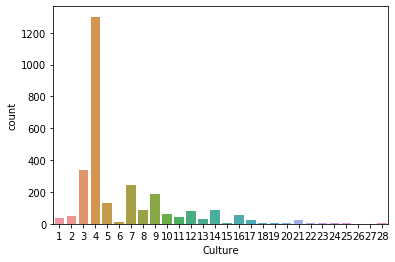

In [6]:
sns.countplot(train['Culture'])

In [7]:
cult_count = train.groupby('Culture')['Culture'].count()
common_cultures = list(cult_count[cult_count>7].index)
rare_cultures = list(cult_count[cult_count<=7].index)
print(f"Редкие классы (меньше 7 экземплярова класса в трейне): {rare_cultures}")
print(f"Доля экземпляров редких классов в трейне от всего обьёма трейна: {train[train.Culture.isin(rare_cultures)].shape[0]/train.shape[0]*100:.3}%")

Редкие классы (меньше 7 экземплярова класса в трейне): [15, 18, 19, 20, 23, 24, 25, 26, 27, 28]
Доля экземпляров редких классов в трейне от всего обьёма трейна: 1.27%


**Наблюдения:**  Явный дисбаланс классов

### Пропущенные значения

 Посмотрим на столбцы, где кол-во пропущенных значений составляет более 25% от выборки

In [8]:
print(f'Train size: {train.shape[0]}')
train_null = train.isnull().sum()
train_null[train_null/train.shape[0] > 0.25]

Train size: 2838


Day 366    2391
dtype: int64

In [9]:
print(f'Test size: {test.shape[0]}')
test_null = test.isnull().sum()
test_null[test_null/test.shape[0] > 0.25]

Test size: 939


Day 291    338
Day 292    460
Day 293    479
Day 294    560
Day 295    415
          ... 
Day 362    934
Day 363    934
Day 364    934
Day 365    934
Day 366    939
Length: 76, dtype: int64

In [10]:
print(f'Train+test size: {full.shape[0]}')
full_null = full.isnull().sum()
full_null[full_null/full.shape[0] > 0.25][:5]

Train+test size: 3777


Day 328    1068
Day 329    1074
Day 330    1221
Day 331    1221
Day 332    1221
dtype: int64

* Видно, что больше всего значений пропущенно в последние 2 месяца. 
* Более того, в тестовой выборке соотношение кол-ва пропущенных к общим значениям за посление 2 месяца вырастает с  приблизитеьно 50% до 100%. 

Возможно, эти месяцы лучше будет исключить.

## Feature engineering

### Агрегирование по месяцам

Чтобы уменьшить размерность, создадим новые признаки, которые будут показывать среднее значение индекса по каждому месяцу.

In [11]:
months = {
    1: ('Day 1', 'Day 31'),
    2: ('Day 32', 'Day 59'),
    3: ('Day 60', 'Day 90'),
    4: ('Day 91', 'Day 120'),
    5: ('Day 121', 'Day 151'),
    6: ('Day 152', 'Day 181'),
    7: ('Day 182', 'Day 212'),
    8: ('Day 213', 'Day 343'),
    9: ('Day 244', 'Day 273'),
    10: ('Day 274', 'Day 304')}

In [12]:
monthly_train = pd.DataFrame()
for key in months:
    monthly_train[key] = train.loc[:, months[key][0]:months[key][1]].mean(axis = 1)
monthly_train[['Year','Field ID','Field Area', 'Culture']] = train[['Year','Field ID','Field Area','Culture']]
monthly_train.head(3)

,1,2,3,4,5,6,7,8,9,10,Year,Field ID,Field Area,Culture
0,0.562606,0.624100,0.631610,0.801607,0.879994,0.562967,0.330203,0.318463,0.265753,0.345381,2018,517,48.64,4
1,0.034458,-0.019171,0.020074,0.281010,0.650181,0.677033,0.737332,0.460947,0.416287,0.354252,2019,1395,80.41,17
2,-0.023316,-0.018068,0.153235,0.247283,0.332584,0.592100,0.752852,0.350657,0.309303,0.395200,2017,44,43.64,2


In [13]:
monthly_test = pd.DataFrame()
for key in months:
    monthly_test[key] = test.loc[:, months[key][0]:months[key][1]].mean(axis = 1)
monthly_test[['Year','Field ID','Field Area']] = test[['Year','Field ID','Field Area']]

#### График среднемесячных индексов по культурам

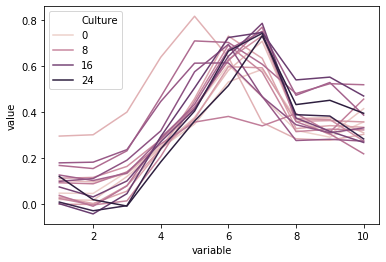

In [14]:
m_ag = monthly_train.drop(['Year','Field ID','Field Area'], axis = 1).groupby('Culture').mean()
m_ag = m_ag.loc[common_cultures]
m_ag.reset_index(inplace = True)
m_ag_melted = pd.melt(m_ag, id_vars=['Culture'])
sns.lineplot(data = m_ag_melted, x='variable', y = 'value', hue = 'Culture')

**Наблюдения:**

* Среди всех культур видена общая тренденция: в зимние месяцы - низкий индекс, в летние - высокий.
* Предположение о том, что нумерация начинается с начала года, подтвердилась.   

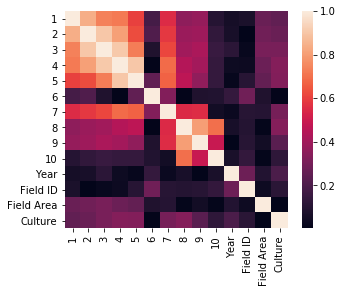

In [15]:
plt.figure(figsize=(5, 4)) 
sns.heatmap(abs(monthly_train.corr()))

### Корень среднемесячного индекса

Так как индекс находится в диапозоне от -1 до 1, то, возможно, взяв корень, мы сможем сделать некоторые классы более различимыми.

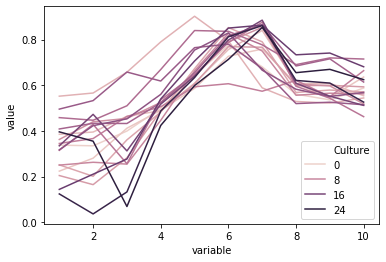

In [16]:
root_train = pd.DataFrame()
for month in range(1,11):
    root_train[month] = monthly_train[month]**(1/2)
root_train['Culture'] = train['Culture']

root_test = pd.DataFrame()
for month in range(1,11):
    root_test[month] = monthly_test[month]**(1/2)
    
m_ag = root_train.groupby('Culture').mean()
m_ag = m_ag.loc[common_cultures]
m_ag.reset_index(inplace = True)
m_ag_melted = pd.melt(m_ag, id_vars=['Culture'])
sns.lineplot(data =m_ag_melted, x='variable', y = 'value', hue = 'Culture')

### Признак (-)/(+)

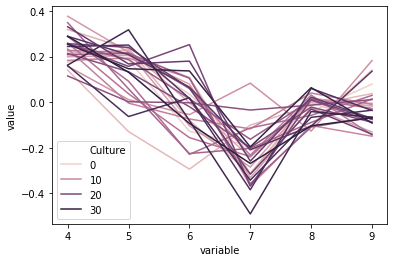

In [17]:
dn_train = pd.DataFrame()
for month in range(1,10):
    dn_train[month] = (monthly_train[month+1]-monthly_train[month])/(monthly_train[month+1]+monthly_train[month])
dn_train['Culture'] = train['Culture']

dn_test = pd.DataFrame()
for month in range(1,10):
    dn_test[month] = (monthly_test[month+1]-monthly_test[month])/(monthly_test[month+1]+monthly_test[month])
    
    
m_ag = dn_train.groupby('Culture').mean()
m_ag.reset_index(inplace = True)
m_ag_melted = pd.melt(m_ag, id_vars=['Culture'])
sns.lineplot(data = m_ag_melted[m_ag_melted.variable.isin(range(4,11))], x='variable', y = 'value', hue = 'Culture')

### Распределение признаков в train и test

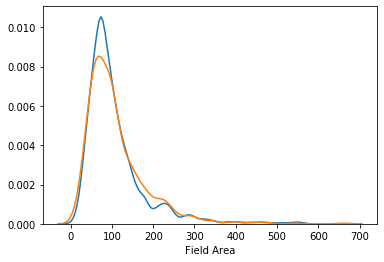

In [18]:
sns.distplot(train['Field Area'], hist=False)
sns.distplot(test['Field Area'], hist=False)

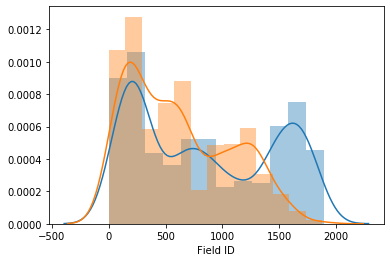

In [19]:
sns.distplot(train['Field ID'])
sns.distplot(test['Field ID'])

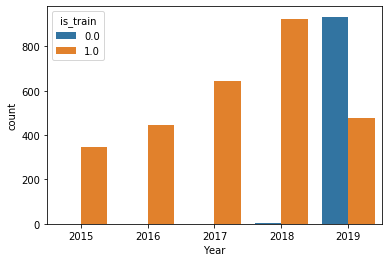

In [20]:
sns.countplot(x = 'Year',data = full, hue = 'is_train')

#### Распределение среднемесячных индексов в train и test по месяцам

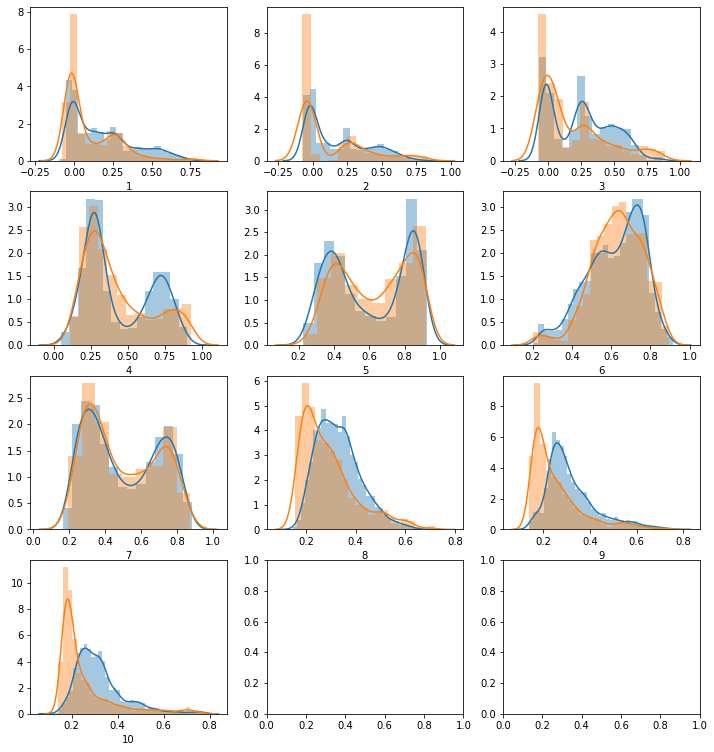

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 13))

for m in range(1,11):
    sns.distplot(monthly_train[m], ax=axes[(m-1) // 3, (m-1) % 3])
    sns.distplot(monthly_test[m], ax=axes[(m-1) // 3, (m-1) % 3])

**Наблюдения:**

Обучающая и тестовая выборки распределены не одинаковым образом:
1. В тесте большинство данных 19 года.
2. В помесячном сравнении до 7 месяца распределение сходжее, однако с 8 месяца распределение теста сдвинуто влево, относительно трейна, в 12 месяце распределения очень отличаются(возможно, из-за очень большого кол-ва пропусков в 12 месяце в тестовой выброрке)


#### Все признаки

In [22]:
monthly_train = monthly_train.drop(['Culture', 'Field Area', 'Year', 'Field ID'], axis=1).add_suffix('_m')
monthly_test = monthly_test.drop(['Field Area', 'Year', 'Field ID'], axis=1).add_suffix('_m')

dn_train = dn_train.drop('Culture', axis=1).add_suffix('_dn')
dn_test = dn_test.add_suffix('_dn')

root_train =root_train.drop('Culture', axis=1).add_suffix('_r')
root_test = root_test.add_suffix('_r')

In [23]:
whole_train = monthly_train.join(dn_train).join(root_train)
whole_train[['Field Area', 'Year', 'Field ID', 'Culture']] = train[['Field Area', 'Year', 'Field ID', 'Culture']]

whole_test = monthly_test.join(dn_test).join(root_test)
whole_test[['Field Area', 'Year', 'Field ID']] = test[['Field Area', 'Year', 'Field ID']]

whole_train.shape, whole_test.shape

((2838, 33), (939, 32))

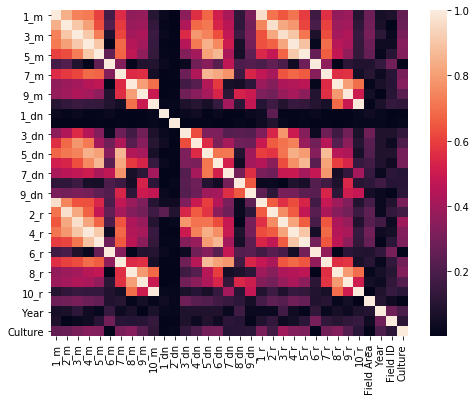

In [24]:
plt.figure(figsize=(8, 6)) 
sns.heatmap(abs(whole_train.corr()))

### Проверка наличия ковариантного сдвига

Чтобы объективно оценить обобщающую способность алгоритма, нужно оценить насколько обучающая и тестовая выборки схожи.

Данный код осован на материалах [этой статьи](https://habr.com/ru/post/422185/)

In [25]:
def cov_shift_df(df_train, df_test):
    train = df_train.drop('Culture', axis = 1)
    test = df_test.copy()

    #найдем столбцы в которых >50% пропусков в тесте и удалим их
    cols = test.isnull().sum() > test.shape[0]*0.5
    train = train.drop(cols[cols].index, axis=1)
    test = test.drop(cols[cols].index, axis=1)
    
    imputer = KNNImputer(n_neighbors=5, weights="distance")

    train  = pd.DataFrame(imputer.fit_transform(train), index = train.index)
    test = pd.DataFrame(imputer.transform(test),index = test.index)
    
    train.columns = df_train.drop('Culture', axis = 1).drop(cols[cols].index, axis = 1).columns
    test.columns = train.columns
    train['Culture'] = df_train['Culture']

    #объединение выборок train, test
    df_combine = pd.concat([train, test], axis=0, ignore_index=True)

    #добавляем новый столбец к данным, нулевой к test, единичный к train
    df_combine['is_train'] = 1
    df_combine.loc[df_combine.Culture.isnull(), 'is_train'] = 0

    #удаление метки 'Culture'
    df_combine = df_combine.drop('Culture', axis =1)

    y = df_combine['is_train'].values #индикатор источника 
    x = df_combine.drop('is_train', axis=1).values #объединенный датасет

    rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5, random_state=31)
    predictions = np.zeros(y.shape) #пустой массив для вероятностей классов

    from sklearn.model_selection import StratifiedKFold, cross_val_score
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=31)
    for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
        X_train, X_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        rfc.fit(X_train, y_train)
        probs = rfc.predict_proba(X_test) #предсказание вероятностей классов
        predictions[test_idx] = probs[:,1]

    from sklearn.metrics import roc_auc_score
    print('Shift ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))
    
    f_i = pd.DataFrame()
    f_i['Features'] = df_train.drop('Culture', axis = 1).drop(cols[cols].index, axis = 1).columns
    f_i['Weights'] = rfc.feature_importances_
    f_i = f_i.sort_values(by='Weights', ascending = False)
    return f_i

In [26]:
cov_shift_feature_importance = cov_shift_df(whole_train, whole_test)
cov_shift_feature_importance[:10]

Shift ROC-AUC: 0.9836495574663343


,Features,Weights
29,Year,0.342788
9,10_m,0.078300
8,9_m,0.074394
30,Field ID,0.066927
27,10_r,0.052805
1,2_m,0.040996
26,9_r,0.039996
2,3_m,0.029433
17,8_dn,0.027884
14,5_dn,0.022080


* ROC AUC близко к 1. То есть, классификатор с хорошо разделяет объекты на обучающий и тестовый датасет. Такая картина свидетельствует о сильном ковариантном сдвиге в данных.
* Признаки, вызывающие наибольший сдвиг, можно попробовать убрать из выборок, особенно если их вклад в предсказательную способность итоговой модели будет небольшим.

# Model training

In [27]:
X_train = whole_train.drop(['Culture'], axis=1)
y_train = whole_train['Culture']
train_indexes = whole_train.index

In [28]:
print(X_train.shape, y_train.shape)

(2838, 32) (2838,)


### Cross-val

In [29]:
# Set our parameter grid
param_grid = { 
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [50, 100, 300],
    'max_features': ['auto', 'log2'],
    'max_depth' : [3, 5, None]    
}

In [30]:
X_tt, X_tv, i_tt, i_tv = train_test_split(X_train, train_indexes, test_size=0.25, random_state=31)

y_tt = y_train[i_tt]
y_tv = y_train[i_tv]

val_indexes = i_tv
val_classes = set(y_tv)

In [31]:
imputer = KNNImputer(n_neighbors=5, weights="distance")

X_tt = pd.DataFrame(imputer.fit_transform(X_tt), index = X_tt.index)
X_tv = pd.DataFrame(imputer.transform(X_tv),index = X_tv.index)
                    
X_tt.columns = X_train.columns
X_tv.columns = X_train.columns

In [32]:
model = RandomForestClassifier(random_state=31)
model_CV = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
model_CV.fit(X_tt, y_tt)
print(model_CV.best_params_)

C:\Users\77\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}


In [33]:
model = RandomForestClassifier(random_state=31,
  criterion = 'entropy',
  max_depth =  None,
  max_features = 'auto',
  n_estimators= 300,
  class_weight ='balanced')
scores = cross_val_score(model, X_tt, y_tt, cv=5, scoring = 'f1_weighted')
print(f"Cross-val-score: {scores.mean():.5f}, std: {scores.std():.3f}")

C:\Users\77\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-val-score: 0.86364, std: 0.023


### Validation

In [34]:
model.fit(X_tt,y_tt)
preds_valid = model.predict(X_tv)

print(f1_score(y_tv, preds_valid, average='weighted'))
print(classification_report(y_tv, preds_valid))

0.8684260165548741
              precision    recall  f1-score   support

           1       0.86      0.67      0.75         9
           2       0.93      1.00      0.96        13
           3       0.79      0.90      0.84        81
           4       0.96      1.00      0.98       335
           5       0.63      0.97      0.76        30
           7       0.81      0.87      0.84        54
           8       0.65      0.55      0.59        20
           9       0.96      0.96      0.96        46
          10       1.00      0.72      0.84        18
          11       0.82      0.75      0.78        12
          12       0.83      0.71      0.77        21
          13       0.00      0.00      0.00        10
          14       1.00      0.75      0.86        20
          15       0.00      0.00      0.00         3
          16       0.83      0.83      0.83        12
          17       1.00      0.83      0.91         6
          18       0.00      0.00      0.00         2
        

C:\Users\77\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
f_i = pd.DataFrame()
f_i['Features'] = X_tt.columns
f_i['Weights'] = model.feature_importances_
f_i.sort_values(by='Weights', ascending = False)

,Features,Weights
25,7_r,0.071562
6,7_m,0.069386
15,6_dn,0.058537
4,5_m,0.046261
23,5_r,0.041998
22,4_r,0.041693
16,7_dn,0.039857
3,4_m,0.037573
14,5_dn,0.036427
31,Field ID,0.036138


**Наблюдения:**
*  Наиболее важны для модели значения индекса в месяцы, когда происходит активый рост растений (апрель-июль), это логично: в другие месяцы, когда поля покрыты снегом или ростки ещё не взошли, индекс будет примерно одинаков вне зависимости от культуры.


In [36]:
to_exclude_rating = cov_shift_feature_importance.merge(f_i, on = 'Features', suffixes = ['_shift', '_importance'])
to_exclude_rating['exclude'] = -0.4*to_exclude_rating['Weights_shift'] + 0.6*to_exclude_rating['Weights_importance']
to_exclude_rating.sort_values(by='exclude')

,Features,Weights_shift,Weights_importance,exclude
0,Year,0.342788,0.020026,-0.125099
1,10_m,0.078300,0.019663,-0.019522
2,9_m,0.074394,0.023678,-0.015551
4,10_r,0.052805,0.021096,-0.008465
3,Field ID,0.066927,0.036138,-0.005088
6,9_r,0.039996,0.023741,-0.001754
5,2_m,0.040996,0.026783,-0.000328
8,8_dn,0.027884,0.025109,0.003912
11,1_dn,0.017198,0.020569,0.005463
7,3_m,0.029433,0.029543,0.005952


Исключим 10 признаков имеющих наименьшее значении в столбце exclude

In [37]:
features_to_exclude = list(to_exclude_rating.sort_values(by='exclude')[:10]['Features'])

In [40]:
def validation(whole_train, whole_test, features_to_exclude):
    
    #splitting
    cov_shift_feature_importance = cov_shift_df(whole_train.drop(columns = features_to_exclude),
                                                whole_test.drop(columns = features_to_exclude))
    
    X_train = whole_train.drop(columns = features_to_exclude).drop(['Culture'], axis=1)
    train_indexes = X_train.index

    y_train = whole_train['Culture']

    X_tt, X_tv, i_tt, i_tv = train_test_split(X_train, train_indexes, test_size=0.25, random_state=31)

    y_tt = y_train[i_tt]
    y_tv = y_train[i_tv]

    val_indexes = i_tv
    val_classes = set(y_tv)
    
    #imputing
    imputer = KNNImputer(n_neighbors=5, weights="distance")

    X_tt = pd.DataFrame(imputer.fit_transform(X_tt), index = X_tt.index)
    X_tv = pd.DataFrame(imputer.transform(X_tv),index = X_tv.index)

    X_tt.columns = X_train.columns
    X_tv.columns = X_train.columns
    
    #cross-validation
    model = RandomForestClassifier(random_state=31,
      criterion = 'entropy',
      max_depth =  None,
      max_features = 'auto',
      n_estimators= 300,
      class_weight ='balanced')
    
    scores = cross_val_score(model, X_tt, y_tt, cv=5, scoring = 'f1_weighted')
    print(f"Cross-val-score: {scores.mean():.5f}, std: {scores.std():.3f}")
    
    #classification report
    model.fit(X_tt,y_tt)
    preds_valid = model.predict(X_tv)

    print(classification_report(y_tv, preds_valid))
    
    #making table
    f_i = pd.DataFrame()
    f_i['Features'] = X_tt.columns
    f_i['Weights'] = model.feature_importances_
    to_exclude_rating = cov_shift_feature_importance.merge(f_i, on = 'Features', suffixes = ['_shift', '_importance'])
    to_exclude_rating['exclude'] = -0.4 * to_exclude_rating['Weights_shift'] + 0.6*to_exclude_rating['Weights_importance']
    return to_exclude_rating

In [41]:
to_exclude_rating = validation(whole_train, whole_test, features_to_exclude)
to_exclude_rating.sort_values(by='exclude')

Shift ROC-AUC: 0.893465451753586


C:\Users\77\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-val-score: 0.82430, std: 0.018
              precision    recall  f1-score   support

           1       0.58      0.78      0.67         9
           2       0.92      0.85      0.88        13
           3       0.75      0.88      0.81        81
           4       0.94      0.99      0.97       335
           5       0.64      0.83      0.72        30
           7       0.73      0.87      0.80        54
           8       0.67      0.50      0.57        20
           9       0.95      0.91      0.93        46
          10       0.80      0.44      0.57        18
          11       0.67      0.50      0.57        12
          12       0.81      0.62      0.70        21
          13       0.33      0.10      0.15        10
          14       0.88      0.75      0.81        20
          15       0.00      0.00      0.00         3
          16       0.70      0.58      0.64        12
          17       0.83      0.83      0.83         6
          18       0.00      0.00      0.00 

C:\Users\77\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Features,Weights_shift,Weights_importance,exclude
1,8_m,0.139016,0.036021,-0.033994
0,8_r,0.143840,0.042745,-0.031889
4,1_m,0.076279,0.031470,-0.011629
2,3_dn,0.092602,0.045276,-0.009875
3,7_dn,0.090584,0.056798,-0.002155
5,4_dn,0.055208,0.040738,0.002359
11,2_dn,0.034489,0.031242,0.004950
13,3_r,0.026307,0.027817,0.006168
20,Field Area,0.005535,0.019265,0.009345
19,9_dn,0.010821,0.026940,0.011836


Несмотря на то, что значение f1 при кросс-вылидации уменьшилось с 0.86 до 0.82, ковариантный свиг между обучающей и тестовой выборкой уменьшился существеннее: с 0.98 до 0.89. Значит, модель переобучается меньше, чем раньше.

Исключим 5 признаков имеющих наименьшее значении в столбце exclude

In [42]:
features_to_exclude.extend(list(to_exclude_rating.sort_values(by='exclude')[:5]['Features']))

to_exclude_rating = validation(whole_train, whole_test, features_to_exclude)
to_exclude_rating.sort_values(by='exclude')

Shift ROC-AUC: 0.8383147921746628


C:\Users\77\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Cross-val-score: 0.77908, std: 0.024
              precision    recall  f1-score   support

           1       0.70      0.78      0.74         9
           2       0.80      0.62      0.70        13
           3       0.65      0.88      0.75        81
           4       0.95      0.99      0.97       335
           5       0.57      0.70      0.63        30
           7       0.66      0.78      0.71        54
           8       0.50      0.40      0.44        20
           9       0.93      0.93      0.93        46
          10       0.67      0.33      0.44        18
          11       0.46      0.50      0.48        12
          12       0.57      0.19      0.29        21
          13       0.20      0.10      0.13        10
          14       1.00      0.60      0.75        20
          15       0.00      0.00      0.00         3
          16       0.50      0.50      0.50        12
          17       0.57      0.67      0.62         6
          18       0.00      0.00      0.00 

C:\Users\77\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Features,Weights_shift,Weights_importance,exclude
0,2_dn,0.129784,0.053272,-0.019950
3,3_r,0.100946,0.041608,-0.015414
2,4_dn,0.105669,0.052969,-0.010486
1,4_m,0.109567,0.065630,-0.004449
6,1_r,0.073051,0.052470,0.002262
4,4_r,0.086454,0.063518,0.003529
7,5_dn,0.061087,0.054358,0.008180
15,Field Area,0.012586,0.027168,0.011267
14,9_dn,0.024615,0.040827,0.014650
10,6_m,0.031848,0.050661,0.017658


Малочисленные культуры модель вообще не присваивает. Можно поробовать вовсе убрать их из обучающей выборки, чтобы лучше предсказавать большие классы, т.к из вес при подсчёте f1 будет больше.

In [43]:
to_exclude_rating = validation(whole_train[whole_train.Culture.isin(common_cultures)], whole_test, features_to_exclude)
to_exclude_rating.sort_values(by='exclude')

Shift ROC-AUC: 0.8454842463811412
Cross-val-score: 0.79346, std: 0.009
              precision    recall  f1-score   support

           1       0.80      0.67      0.73         6
           2       0.67      0.67      0.67        12
           3       0.73      0.85      0.78        97
           4       0.96      1.00      0.98       323
           5       0.70      0.77      0.73        39
           6       1.00      0.17      0.29         6
           7       0.58      0.81      0.68        52
           8       0.68      0.57      0.62        23
           9       0.94      0.94      0.94        35
          10       0.57      0.40      0.47        20
          11       0.55      0.75      0.63         8
          12       0.56      0.20      0.29        25
          13       1.00      0.17      0.29        12
          14       0.87      0.76      0.81        17
          16       0.89      0.57      0.70        14
          17       0.50      0.14      0.22         7
          

C:\Users\77\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Features,Weights_shift,Weights_importance,exclude
0,2_dn,0.148617,0.053038,-0.027624
5,1_r,0.075243,0.026467,-0.014217
2,3_r,0.100221,0.050658,-0.009694
1,4_m,0.110016,0.062111,-0.006740
4,4_r,0.092330,0.054209,-0.004407
3,4_dn,0.095311,0.058085,-0.003273
6,5_dn,0.056674,0.056707,0.011355
7,5_r,0.055610,0.056526,0.011671
15,Field Area,0.008840,0.025829,0.011961
8,5_m,0.053537,0.060402,0.014826


### Prediction

In [49]:
X_train = whole_train[whole_train.Culture.isin(common_cultures)].drop(['Culture'], axis=1).drop(columns = features_to_exclude)
X_test = whole_test.drop(columns = features_to_exclude)
y_train = whole_train[whole_train.Culture.isin(common_cultures)]['Culture']

imputer = KNNImputer(n_neighbors=5, weights="distance")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [50]:
model = RandomForestClassifier(random_state=31)
model_CV = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
model_CV.fit(X_train, y_train)
model_CV.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 300}

In [51]:
model = RandomForestClassifier(random_state=567,
  criterion = 'entropy',
  max_depth =  None,
  max_features = 'auto',
  n_estimators= 300,
  class_weight ='balanced')

model.fit(X_train, y_train)
preds = model.predict(X_test)

#pd.Series(preds).to_csv('preds.csv', index=False, header=['Culture'])

## P.S.
Для более простого востприятия неоправдавшиеся идеи и гипотезы не были включены в финальный код.

**Что ещё можно было попробовать:**
1. Посроить бинарные классификаторы отдельно для тех классов, которые изначальный классификатор часто путает, например, 3 и 7 , 5 и 8 культуры. (Было начато, но из-за того, что на промежуточном этапе результат не улучшался, идею пришлось отложить) 
2. Т.к. не рекомендуется на один участок несколько лет подряд сажать одну и ту же культуру (и, если судить по обучающей выборке, в целом это правило здесь соблюдается), можно было собрать информацию для каждого поля и использовать при обучении. (Не было реализовано, потому что предсказания модели редко нарушали правило, а делать проверку для каждого предсказания и поля было бы долго).